# Fine-tuning Mistral7B on Subjectivity Detection

To install the required libraries if you are not working locally <br>
!pip install -U bitsandbytes -t "/users/llmlrl/jbienass/.local/bin" <br>
!pip install -q -U transformers <br>
!pip install -q -U peft -t "/users/llmlrl/jbienass/.local/bin" <br>
!pip install -q -U accelerate <br>
!pip install -q -U datasets <br>
!pip install -q -U trl -t "/users/llmlrl/jbienass/.local/bin" <br>
!pip install -q -U pillow

!pip install -q -U pillow

In [1]:
# Importing necessary libraries for data manipulation, visualization, and displaying progress bars.
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm  

In [2]:
# Importing necessary libraries from the transformers ecosystem for handling language models and custom training configurations.
# bitsandbytes provides efficient CUDA implementations for deep learning training, particularly useful for embedding tables and custom optimizers.
import bitsandbytes as bnb
# transformers includes classes for easily downloading and using pre-trained transformer models, such as GPT, BERT, etc...
from transformers import (
AutoModelForCausalLM,
AutoTokenizer,
BitsAndBytesConfig,
TrainingArguments,
)
# peft provides tools for efficient fine-tuning and parameter-efficient training of transformer models.
from peft import LoraConfig, PeftModel, get_peft_model, prepare_model_for_kbit_training
# accelerate is a library designed to simplify running machine learning models on multi-GPU or TPU setups.
from accelerate import Accelerator
# datasets is a library for easily loading and manipulating datasets, particularly useful for NLP tasks.
from datasets import load_dataset, list_datasets
# trl is for training transformer models using reinforcement learning techniques, particularly useful for tasks like optimizing specific behaviors in language models.
from trl import SFTTrainer
# torch is the primary library for tensor computation and neural network training, serving as the backbone for most deep learning tasks.
import torch

Process ForkProcess-4:
Process ForkProcess-3:
Process ForkProcess-2:
Process ForkProcess-1:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3

## Loading Training Datasets

In [3]:
# If you want to use notebook login
#from huggingface_hub import notebook_login
#notebook_login()

In [4]:
data = load_dataset("j03x/CheckThat2023")

In [5]:
data

DatasetDict({
    train: Dataset({
        features: ['sentence_id', 'sentence', 'label', 'solved_conflict'],
        num_rows: 830
    })
    validation: Dataset({
        features: ['sentence_id', 'sentence', 'label', 'solved_conflict'],
        num_rows: 219
    })
})

In [6]:
#Data pre-processing
data['train'] = data['train'].remove_columns(['sentence_id', 'solved_conflict'])
data['validation'] = data['validation'].remove_columns(['sentence_id', 'solved_conflict'])

#Unlabeled validation data used for testing Mistral7B without fine-tuning
data_validation_unlabeled = data['validation'].remove_columns(['label'])

In [7]:
data

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 830
    })
    validation: Dataset({
        features: ['sentence', 'label'],
        num_rows: 219
    })
})

In [8]:
data_validation_unlabeled

Dataset({
    features: ['sentence'],
    num_rows: 219
})

In [9]:
#If you want to check the format uncomment
#for sample in data_validation_unlabeled:
  #print(sample)

## Loading Test Datasets

In [10]:
test_data = load_dataset("j03x/CheckThat2023_Test")
test_data = test_data.remove_columns(['sentence_id'])

In [11]:
test_data

DatasetDict({
    test: Dataset({
        features: ['sentence'],
        num_rows: 243
    })
})

In [12]:
test_data_gold =  load_dataset("j03x/CheckThat2023_Test_gold_en")

In [13]:
test_data_gold

DatasetDict({
    test: Dataset({
        features: ['sentence_id', 'sentence', 'label'],
        num_rows: 243
    })
})

## Loading the Fine-Tuned Model

We're going to load our model in `4bit`, with double quantization, with `bfloat16` as our compute dtype.

We're loading the instruct-tuned model - this is because it's already adept at following tasks - we're teaching it a new one.

In [14]:
#Quantization configuration
bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16,
        bnb_4bit_use_double_quant=True,
)
#model_name = "mistralai/Mistral-7B-Instruct-v0.1"
model_name="Mistral_finetuned_test1" #Fine_tuned model
model = AutoModelForCausalLM.from_pretrained(
          model_name, quantization_config=bnb_config, device_map={"": 0}
)

tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-v0.1")
tokenizer.pad_token = tokenizer.unk_token
tokenizer.pad_token_id =  tokenizer.unk_token_id
tokenizer.padding_side = 'left'


#Cast some modules of the model to fp32 
model = prepare_model_for_kbit_training(model)
#Configure the pad token in the model
model.config.pad_token_id = tokenizer.pad_token_id
model.config.use_cache = False # Gradient checkpointing is used by default but not compatible with caching

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## FineTuning section, To use if you want to retrain the model on your data

In [15]:
#peft_config = LoraConfig(
#        lora_alpha=16,
#        lora_dropout=0.1,
#        r=16,
#        bias="none",
#        task_type="CAUSAL_LM",
#        target_modules= ['k_proj', 'q_proj', 'v_proj', 'o_proj', "gate_proj", "down_proj", "up_proj"]
#)

In [16]:
#training_arguments = TrainingArguments(
#        output_dir="./v2_mistral7b_results",
#        evaluation_strategy="steps",
#        do_eval=True,
#        optim="paged_adamw_8bit",
#        per_device_train_batch_size=4,
#        gradient_accumulation_steps=2,
#        per_device_eval_batch_size=12,
#        log_level="debug",
#        logging_steps=10,
#        learning_rate=1e-4,
#        eval_steps=20,
        #num_train_epochs=1, #uncomment if you want to train using epochs
#        max_steps=100,       #comment if you want to train using epochs
#        save_steps=25,
#        warmup_steps=0.03,
#        lr_scheduler_type="constant",
#        ddp_find_unused_parameters = False  #important for vanishing gradient
#)

In [17]:
#trainer = SFTTrainer(
#        model=model,
#        train_dataset=data['train'].rename_column("sentence", "text"),
#        eval_dataset=data['validation'].rename_column("sentence", "text"),
#        peft_config=peft_config,
#        dataset_text_field="text",
#        max_seq_length=1024,
#        tokenizer=tokenizer,
#        args=training_arguments,
#)

#trainer.train()

In [18]:
#trainer.save_model("Mistral_finetuned_test1")

## Create Formatted Prompt

In the following function we'll be  creating the following template:

```
<s>### Instruction:
Our task is to evaluate whether a text is subjective or objective. Subjectivity is a characteristic of language: when uttering a statement, the speaker simultaneously expresses their position, attitude, and feelings towards the statement, thus leaving their own imprint. If the text is not subjective, it is considered objective. Respond only with OBJ for objective or SUBJ for subjective.

### Input:
{input}

### Response:
{response}</s>
```

In [19]:
system_message = "Your task is to evaluate whether a text is subjective or objective. Subjectivity is a characteristic of language: when uttering a statement, the speaker simultaneously expresses their position, attitude, and feelings towards the statement, thus leaving their own imprint. If the text is not subjective, it is considered objective. Your output is only OBJ for objective or SUBJ for subjective."

### Zero shot

In [20]:
def create_prompt(system_message, sample):
    """
    Constructs a full prompt for a language model based on a given system message and sample input.
    
    This function builds a structured prompt that includes an instruction section, an input section,
    and a placeholder for the response section. The prompt is constructed in a format that is typically
    used for conditioning language models to perform specific tasks based on the given input and instructions.
    
    Parameters:
    - system_message (str): The instruction or context to provide to the model, detailing what kind of response is expected.
    - sample (dict): A dictionary containing the input data. The function expects this dictionary to have a key 'sentence'
                     that corresponds to the input text to be included in the prompt.
    
    Returns:
    - str: A fully constructed prompt string that includes the instruction, the input text, and a placeholder for the response.
    """
    input_text = sample["sentence"]

    full_prompt = ""
    full_prompt += "### Instruction:"
    full_prompt += "\n" + system_message
    full_prompt += "\n\n### Input:"
    full_prompt += "\n" + input_text
    full_prompt += "\n\n### Response:"

    return full_prompt


In [21]:
prompt_test_zero_shot=create_prompt(system_message, data_validation_unlabeled[2])
print(prompt_test_zero_shot)

### Instruction:
Your task is to evaluate whether a text is subjective or objective. Subjectivity is a characteristic of language: when uttering a statement, the speaker simultaneously expresses their position, attitude, and feelings towards the statement, thus leaving their own imprint. If the text is not subjective, it is considered objective. Your output is only OBJ for objective or SUBJ for subjective.

### Input:
These issues include punishing Sanctuary Cities and increasing deportations.

### Response:


### Few shot

In [22]:
def create_few_shot_prompt(system_message, few_shot_examples, new_input):
    """
    Constructs a few-shot learning prompt for a language model based on a system message, a set of few-shot examples,
    and a new input for which the response is solicited.

    This function generates a structured prompt that includes several few-shot examples followed by a new input,
    each within their respective sections. This format is designed to aid language models in understanding the task context
    through examples and then applying that understanding to generate a response for the new input.

    Parameters:
    - system_message (str): A sentence or instruction provided at the beginning of the prompt to describe the task or context.
    - few_shot_examples (list of dicts): A list of examples where each example is a dictionary containing a 'sentence' and a 'label'.
                                        These examples are used to illustrate the task to the model.
    - new_input (dict): A dictionary containing the 'sentence' for the new input. This is the sentence for which the model
                        needs to generate a response or prediction.

    Returns:
    - str: A string representing the full prompt for few-shot learning, including the provided examples and the new input,
           all formatted with appropriate headers for each section.
    """
    full_prompt = "### Sentence:\n" + system_message
    for example in few_shot_examples:
        full_prompt += "\n\n### Input:\n" + example["sentence"]
        full_prompt += "\n\n### Response:\n" + example["label"]
    
    full_prompt += "\n\n### Input:\n" + new_input["sentence"]
    full_prompt += "\n\n### Response:"
    
    return full_prompt


In [23]:
example = [
    {"sentence": "The sky is blue.", "label": "OBJ"},
    {"sentence": "I love sunny days.", "label": "SUBJ"},
    {"sentence": "Data indicates a rise in temperature.", "label": "OBJ"},
    {"sentence": "Nothing beats a walk in the park on a sunny day.", "label": "SUBJ"},  
]

In [24]:
prompt_test_few_shot=create_few_shot_prompt(system_message, example, data_validation_unlabeled[2])
print(prompt_test_few_shot)

### Sentence:
Your task is to evaluate whether a text is subjective or objective. Subjectivity is a characteristic of language: when uttering a statement, the speaker simultaneously expresses their position, attitude, and feelings towards the statement, thus leaving their own imprint. If the text is not subjective, it is considered objective. Your output is only OBJ for objective or SUBJ for subjective.

### Input:
The sky is blue.

### Response:
OBJ

### Input:
I love sunny days.

### Response:
SUBJ

### Input:
Data indicates a rise in temperature.

### Response:
OBJ

### Input:
Nothing beats a walk in the park on a sunny day.

### Response:
SUBJ

### Input:
These issues include punishing Sanctuary Cities and increasing deportations.

### Response:


## Response generation

In [25]:
def generate_response(prompt, model):
    """
    Generates a response from a given language model based on the input prompt. This function encodes the prompt,
    sends it to the specified model, and decodes the generated response to return it as a string.

    The function first encodes the prompt using a tokenizer assumed to be available in the calling scope,
    then forwards this encoded input to the model. The model's response is decoded back into a string, and
    the part of the output that corresponds to the input prompt is removed, leaving only the model's generated response.

    Parameters:
    - prompt (str): The input text to which the model should respond. The prompt is used to set the context or ask a question.
    - model (transformers.PreTrainedModel): The pre-trained language model that will generate the response. This model
                                             should be loaded and possibly fine-tuned before being passed to this function.

    Returns:
    - str: The generated text response from the model. This response is processed to remove the original prompt, leaving
           only the new content that was generated by the model.

    Note:
    - This function assumes that 'tokenizer' is globally available and it is compatible with the provided model.
    - The function also assumes that the model and tokenizer are set up for GPU usage ('cuda').
    """
    encoded_input = tokenizer(prompt, return_tensors="pt", add_special_tokens=True)
    model_inputs = encoded_input.to('cuda')

    generated_ids = model.generate(**model_inputs, max_new_tokens=1000, do_sample=True, pad_token_id=tokenizer.unk_token_id)

    decoded_output = tokenizer.batch_decode(generated_ids)

    return decoded_output[0].replace(prompt, "")


In [26]:
generate_response(prompt_test_zero_shot, model)

'<s>  SUBJ</s>'

In [27]:
generate_response(prompt_test_few_shot, model)

'<s> \nOBJ</s>'

## Results generation

In [28]:
def process_validation_dataset(dataset, model, tokenizer):
    """
    Processes a given dataset to generate responses from a language model for each entry. This function iteratively
    creates prompts from the dataset samples, generates responses using the language model, and collects these responses.

    The function loops over each entry in the provided dataset, constructs a prompt using a predefined function
    'create_prompt', generates a response using the 'generate_response' function , and aggregates all responses.

    Parameters:
    - dataset (iterable): An iterable dataset where each element is a data point that can be used to generate a prompt.
                          The exact structure of these data points should be compatible with the 'create_prompt' function.
    - model (transformers.PreTrainedModel): The language model used to generate responses.
    - tokenizer (transformers.PreTrainedTokenizer): The tokenizer used for encoding prompts and decoding responses, which
                                                    should be compatible with the provided model.

    Returns:
    - list: A list of generated text responses for each entry in the provided dataset.

    Notes:
    - The 'create_prompt' function is used to construct prompts from the dataset samples and must be defined and accessible
      within the same scope as this function.
    - The 'generate_response' function is responsible for generating responses from the model based on the prompts and must
      also be defined and accessible within the same scope.
    - The loop can be optionally limited by a counter to process only a subset of the dataset for testing or demonstration purposes.
    """
    generated_responses = []
    #counter= 0
    
    for sample in tqdm(dataset):
        prompt = create_prompt(system_message, sample)
        response = generate_response(prompt, model)
        generated_responses.append(response)
        
        #counter+=1
        #if counter == 30: 
            #break

    return generated_responses

In [29]:
def extract_labels(responses):
    """
    Extracts generated labels from responses and compares them with actual labels from a validation dataset.
    
    This function processes a list of generated text responses, extracting the label part from each response. It assumes
    that the last line of each response contains the label information. The function then retrieves the actual labels
    from a global dataset variable assumed to be named 'data' with a 'validation' key. It checks the alignment between
    the lengths of generated labels and actual labels to ensure they correspond to each other. Finally, it encapsulates
    this information into a pandas DataFrame for easy comparison and analysis.

    Parameters:
    - responses (list of str): A list containing the text responses from which labels need to be extracted. Each response
                               is expected to have its label on the last line.

    Returns:
    - tuple: A tuple containing three elements:
        - df (pandas.DataFrame): A DataFrame with two columns, 'Generated Label' and 'Actual Label', representing the labels
                                 extracted from the generated responses and the actual labels from the dataset, respectively.
        - y_true (pandas.Series): A Series object representing the actual labels extracted directly from the dataset.
        - y_pred (pandas.Series): A Series object representing the labels extracted from the generated responses.

    Notes:
    - The function assumes that there is a global variable 'data' accessible within the scope that contains the actual labels
      in its 'validation' section.
    - The function uses simple string operations to extract labels and assumes the format of the generated responses is consistent.
    - An assertion is used to verify the alignment between the number of generated labels and actual labels, ensuring data integrity.
    """
    extracted_labels = [response.split('\n')[-1].strip('</s>') for response in responses]
    actual_labels = [sample['label'] for sample in data['validation']]

    assert len(extracted_labels) == len(actual_labels), "The lengths of generated and actual labels don't match."

    df = pd.DataFrame({
        'Generated Label': extracted_labels,
        'Actual Label': actual_labels
    })
    y_true = df['Actual Label']
    y_pred = df['Generated Label']
    
    return df, y_true, y_pred


In [30]:
def display_confusion_matrix(y_true, y_pred):
    """
    Displays a confusion matrix visualization for the given true and predicted labels.

    Parameters:
    - y_true (list or array-like): The true labels against which the predicted labels are evaluated. This should be a list
                                   or an array-like structure containing the actual classification labels.
    - y_pred (list or array-like): The predicted labels that are to be evaluated. This should be a list or an array-like
                                   structure containing the labels predicted by the classification model.

    Returns:
    - None: This function does not return any value. It directly displays the confusion matrix plot.

    Notes:
    - The function is configured to specifically handle binary classification outcomes labeled as "SUBJ" and "OBJ".
    - The confusion matrix is plotted using seaborn's heatmap function for better readability and understanding. The figure size,
      color mapping, and labels are all customizable parameters within the seaborn.heatmap function that can be adjusted for
      different visualization needs.
    - It is important that the length of 'y_true' and 'y_pred' match and they correctly correspond to each other.
    """
    cm = confusion_matrix(y_true, y_pred, labels=["SUBJ", "OBJ"])

    # Visualization
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["SUBJ", "OBJ"], yticklabels=["SUBJ", "OBJ"])
    plt.title("Confusion Matrix")
    plt.ylabel("Actual Label")
    plt.xlabel("Generated Label")
    plt.show()


In [31]:
def mismatched_rows(df):
    """
    Identifies and extracts rows from a DataFrame where the actual and generated labels do not match.

    This function is particularly useful for analyzing and understanding the instances where the model's predictions
    did not align with the actual labels, enabling detailed examination of those specific cases. It filters the
    DataFrame based on a condition where the 'Actual Label' and 'Generated Label' columns are not equal, thereby
    isolating the rows representing mismatches between predicted and true values.

    Parameters:
    - df (pandas.DataFrame): The DataFrame containing the comparison between actual and generated labels. This DataFrame
                             should have at least two columns: 'Actual Label' and 'Generated Label'.

    Returns:
    - pandas.DataFrame: A new DataFrame containing only the rows where the actual and generated labels are different,
                        thereby highlighting the mismatches.

    Notes:
    - The function assumes the input DataFrame has the specific columns 'Actual Label' and 'Generated Label'. If these columns
      are not present, the function will raise a KeyError.
    - No changes are made to the original DataFrame; a filtered version is returned.
    """
    mismatch_mask = df['Actual Label'] != df['Generated Label']
    mismatched_rows = df[mismatch_mask]
    
    return mismatched_rows


### On training data (dev or validation split)

In [32]:
generated_responses = process_validation_dataset(data_validation_unlabeled, model, tokenizer)

100%|██████████| 219/219 [05:18<00:00,  1.46s/it]


In [33]:
generated_responses = ['<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nOBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nOBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nOBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nOBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nOBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nOBJ</s>', '<s> \nSUBJ</s>', '<s> \nOBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nOBJ</s>', '<s> \nSUBJ</s>', '<s> \n\n SUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nOBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s>  \nOBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nOBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s>  \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nOBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s>  SUBJ.</s>', '<s> \nSUBJ</s>', '<s> \nOBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nOBJ</s>', '<s> \nOBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nOBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nOBJ</s>', '<s> \nOBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nOBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nOBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nOBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nOBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nOBJ</s>', '<s> \nOBJ</s>', '<s> \nSUBJ</s>', '<s>  \nOBJ</s>', '<s> \n SUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nOBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nOBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nOBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nOBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s>  \nOBJ</s>', '<s> \nOBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nOBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nOBJ</s>', '<s> \nSUBJ</s>', '<s>  \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nOBJ</s>', '<s>  \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nOBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nOBJ</s>', '<s> \nSUBJ</s>', '<s> \nOBJ</s>', '<s> \nOBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nOBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nOBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nOBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nOBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>']


In [34]:
print(generated_responses)

['<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nOBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nOBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nOBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nOBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nOBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nOBJ</s>', '<s> \nSUBJ</s>', '<s> \nOBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nOBJ</s>', '<s> \nSUBJ</s>', '<s> \n\n SUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nOBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>

In [35]:
df, y_true, y_pred =extract_labels(generated_responses)
df

,Generated Label,Actual Label
0,SUBJ,SUBJ
1,SUBJ,SUBJ
2,SUBJ,OBJ
3,SUBJ,OBJ
4,SUBJ,OBJ
...,...,...
214,OBJ,SUBJ
215,SUBJ,SUBJ
216,SUBJ,SUBJ
217,SUBJ,SUBJ


In [36]:
#Classification report
report = classification_report(y_true, y_pred)
print(report)

              precision    recall  f1-score   support

       SUBJ.       0.00      0.00      0.00         0
        SUBJ       0.00      0.00      0.00         0
         OBJ       0.67      0.26      0.38       106
        SUBJ       0.56      0.87      0.68       113

    accuracy                           0.58       219
   macro avg       0.31      0.28      0.27       219
weighted avg       0.61      0.58      0.54       219



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


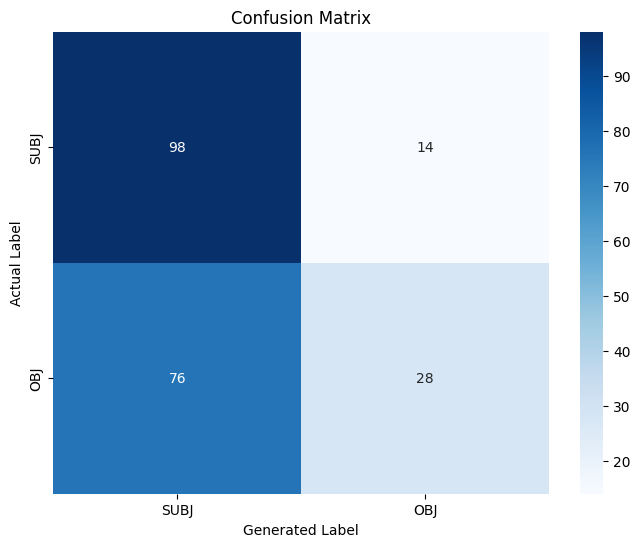

In [37]:
display_confusion_matrix(y_true, y_pred)

### On test Data

In [38]:
generated_responses_test = process_validation_dataset(test_data['test'], model, tokenizer)

100%|██████████| 243/243 [05:54<00:00,  1.46s/it]


In [39]:
print(generated_responses_test)

['<s>   SUBJ</s>', '<s>  \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nOBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s>  SUBJ</s>', '<s> \nSUBJ</s>', '<s>  SUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s>   SUBJ</s>', '<s>  \nOBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s>  SUBJ</s>', '<s>  SUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nOBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nOBJ</s>', '<s> \nOBJ</s>', '<s>  \nSUBJ</s>', '<s> \nOBJ</s>', '<s>  \nSUBJ</s>', '<s>   SUBJ</s>', '<s> \nOBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s>   \nSUBJ</s>', '<s>  SUBJ</s>', '<s>  \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nSUBJ</s>', '<s> \nOBJ</s>

In [40]:
print(generated_responses_test[0].replace("<s>", "").replace("</s>", "").replace("\n", "").replace(" ", ""))

SUBJ


In [41]:
def find_good_responses(responses):
    """
    Processes a list of response strings, filters out the valid and succinct responses, and counts them.
    The function checks each response after cleaning it (removing specific characters and spaces) to determine
    if it is either "SUBJ" or "OBJ" and is shorter than 15 characters. It updates valid responses in place and
    marks others as 'ERROR'. The function ultimately returns the count of valid responses.

    Parameters:
    - responses (list of str): The list of response strings to be evaluated. These responses are presumably
                               output from a model and need to be assessed for their relevance and correctness.

    Returns:
    - int: The number of responses that were considered valid based on the function's criteria.

    Notes:
    - This function directly modifies the input list, replacing each response with 'ERROR' if it doesn't meet
      the validity criteria.
    - The validity criteria are specific: a response must be either "SUBJ" or "OBJ" and less than 15 characters in length.
    - The function assumes that the response strings have certain formatting that includes "<s>", "</s>", and new lines,
      all of which are stripped during processing.
    """
    res = 0
    for counter, elem in enumerate(responses):
        cleaned_elem = elem.replace("<s>", "").replace("</s>", "").replace("\n", "").replace(" ", "")
        responses[counter] = cleaned_elem
        if len(cleaned_elem) < 15 and (cleaned_elem == "SUBJ" or cleaned_elem == "OBJ"):
            res += 1
        else:
            responses[counter] = 'ERROR'
    return res
        



res= find_good_responses(generated_responses_test)
print(res)

230


In [42]:
print("pourcentage de bon retours =", 230/243*100, "%")

pourcentage de bon retours = 94.65020576131687 %


In [43]:
report = classification_report(test_data_gold['test']['label'], generated_responses_test)
print(report)

              precision    recall  f1-score   support

       ERROR       0.00      0.00      0.00         0
         OBJ       0.68      0.18      0.29       116
        SUBJ       0.56      0.88      0.69       127

    accuracy                           0.55       243
   macro avg       0.41      0.35      0.32       243
weighted avg       0.62      0.55      0.50       243



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


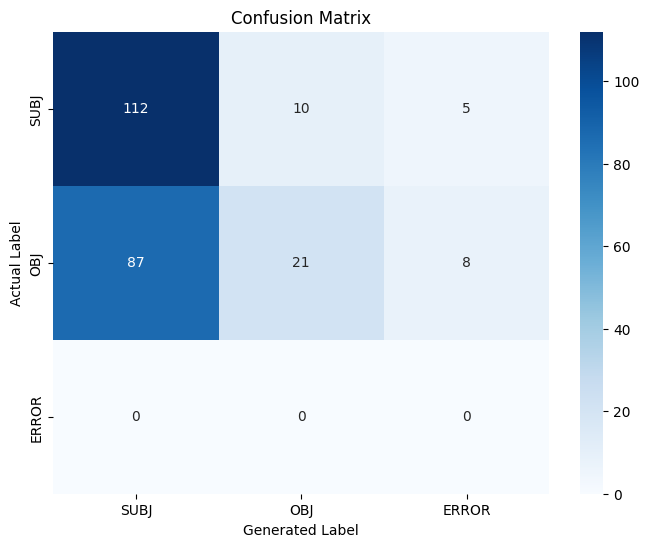

In [44]:
# displaying confusion matrix with an additional error class
cm = confusion_matrix(test_data_gold['test']['label'], generated_responses_test, labels=["SUBJ", "OBJ", "ERROR"])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["SUBJ", "OBJ", "ERROR"], yticklabels=["SUBJ", "OBJ", "ERROR"])
plt.title("Confusion Matrix")
plt.ylabel("Actual Label")
plt.xlabel("Generated Label")
plt.show()